# Behavior Preprocessing

## Initialization

In [1]:
%reset -f
import pandas as pd
import numpy as np
from grabbit import Layout
import os
from msit import extract_itis, encode_trial_type_sequence 
from msit import encode_post_error, denote_exclusions, encode_target_location
from pandas.util.testing import assert_frame_equal
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', font_scale=2)

layout = Layout('../data', '../data/grabbit_config.json')

## Make Group DataFrame 

In [3]:
# Accumulate individual dataframes to be concatenated at the end
tidy_df = []

# Iterate through the two modalities
# func = fmri
for modality in ['eeg', 'func']:
    
    # Extract out behavior filepaths for all subjects
    behavior_files = layout.get(subject='sub-.*', modality=modality, 
                                extensions='events.tsv')
    
    # Iterate through each subject's behavior file
    for f in behavior_files:
        
        raw_df = pd.read_csv(f.filename, sep='\t', na_values='n/a')
        
        # Encode subject name
        raw_df['participant_id'] = f.subject
        
        # Encode modality
        if modality == 'func':
            raw_df['modality'] = 'fmri'
        else:
            raw_df['modality'] = 'eeg'
            
        # Extract out the itis
        raw_df = extract_itis(raw_df)
        
        # Remove the fixation trials
        trial_ix = raw_df.trial_type != 'fixation'
        raw_df = raw_df[trial_ix].reset_index(drop=True)
        
        # Encode error trials
        raw_df['error'] = 1 - raw_df.response_accuracy
        
        # Encode post error trials
        raw_df = encode_post_error(raw_df)
        
        # Encode no-response trials
        raw_df['no_response'] = 0
        raw_df.loc[raw_df.chosen_response.isnull(), 'no_response'] = 1
        
        # Encode condition sequence effects
        raw_df = encode_trial_type_sequence(raw_df)
        
        # Encode fast response times (< 200 ms)
        raw_df['fast_rt'] = np.where(raw_df.response_time < 0.2, 1, 0)
        
        # Encode target location
        raw_df = encode_target_location(raw_df)
        
        # Encode trial numbers
        raw_df['trial'] = np.arange(raw_df.shape[0]) + 1

        tidy_df.append(raw_df)
        
tidy_df = pd.concat(tidy_df)

# Select out and order columns
tidy_df = tidy_df[['participant_id', 'modality', 'trial', 'onset', 
                   'duration', 'iti', 'trial_type', 'response_time', 
                   'chosen_response', 'correct_response', 'target_location',
                   'response_accuracy', 'stimulus', 'error', 'post_error', 
                   'no_response', 'trial_type_sequence', 'fast_rt']]
print(tidy_df.head())

# Save out to file
if not os.path.exists('../data/derivatives/behavior'):
    os.makedirs('../data/derivatives/behavior')
tidy_df.to_csv('../data/derivatives/behavior/group_data.tsv', sep='\t',
               index=False, na_rep='n/a')

  participant_id modality  trial    onset  duration   iti   trial_type  \
0      sub-hc001      eeg      1   2.2840      1.75  2.00  incongruent   
1      sub-hc001      eeg      2   6.0330      1.75  1.75    congruent   
2      sub-hc001      eeg      3   9.5346      1.75  2.00  incongruent   
3      sub-hc001      eeg      4  13.2872      1.75  1.75    congruent   
4      sub-hc001      eeg      5  16.7972      1.75  1.75    congruent   

   response_time  chosen_response  correct_response target_location  \
0        0.87199              2.0                 2           right   
1        0.71505              3.0                 3           right   
2        1.14070              1.0                 2            left   
3        0.59579              2.0                 2          middle   
4        0.67779              1.0                 1            left   

   response_accuracy stimulus  error  post_error  no_response  \
0                1.0      332    0.0           0            0  

## Validate Task Design

### Check Consistency Across Subjects

The first check for our data is whether the task design (trial sequences, durations, iti's, etc.) are actually consistent across participants (within modalities). The cell below checks this by extracting out the task design columns (trial duration, iti, stimulus shown, correct_reponse, and trial_type_sequence) for each participant as inidividual dataframes and then comparing them all to the first participant to ensure equality.

In [8]:
tidy_df = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                      sep='\t', na_values='n/a')

# hierachical index
tidy_df = tidy_df.set_index(['participant_id', 'modality', 'trial'])

# filter to columns corresponding to task design that should be identical
columns = ['duration', 'iti', 'stimulus', 'correct_response', 
           'trial_type_sequence']
tidy_df = tidy_df[columns]

for modality in ['eeg', 'fmri']:

    # screen to given modality
    mod_df = tidy_df.xs(modality, level='modality') 
    
    # extract list of individual participants
    subject_dfs = [mod_df.xs(pid, level='participant_id') for pid in 
                   mod_df.index.get_level_values(0).unique()]
    
    # iterate through asserting that all participant dataframes are
    # equivalent to first dataframe (and thus to each other)
    for i in range(1, len(subject_dfs)):
        assert_frame_equal(subject_dfs[0], subject_dfs[i])

We see no output... which is good! This means our assertion that all of the participant task design dataframes within each modality were equal did not fail. All participants received the same design as intended. 

### Verify Task Design Parameters 

In the next series of cells, we will extract and verify a set of important parameters regarding our task design. We'll also reveal any differences between the EEG and fMRI design as well. Since we've already verified that our task design is identical across subjects, we'll select out only the first subject's dataframe and analyze their task design information knowing that it is equivalent for all other subjects.

In [9]:
tidy_df = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                      sep='\t', na_values='n/a')
tidy_df = tidy_df.set_index(['participant_id', 'modality', 'trial'])
tidy_df = tidy_df.xs('sub-hc001', level='participant_id')

#### Trial Counts

The main contrast of interest is incongruent vs. congruent trials:

In [10]:
tidy_df.groupby([pd.Grouper(level=0), 'trial_type']).onset.count()

modality  trial_type 
eeg       congruent      96
          incongruent    96
fmri      congruent      96
          incongruent    96
Name: onset, dtype: int64

Researchers have also traditionally looked at the effect of the previous trial type as a proxy for the effect of "conflict adaptation". For example, one would expect a person to be better at resolving an incongruent if they had more recently had to resolve such a trial.

In [11]:
tidy_df.groupby([pd.Grouper(level=0), 'trial_type_sequence']).onset.count()

modality  trial_type_sequence
eeg       cc                     47
          ci                     48
          ic                     49
          ii                     47
fmri      cc                     48
          ci                     47
          ic                     48
          ii                     48
Name: onset, dtype: int64

Interestingly, we don't quite have a balance in the eeg design (one more ic than there should be). Since we have an even number of trials there are an odd number of sequences and thus we can't have a perfect balance as one condition must have one less.

#### Trial Sequences

To develop some intution about the full trial sequences, let's plot a smoothed version of the condition sequences. 

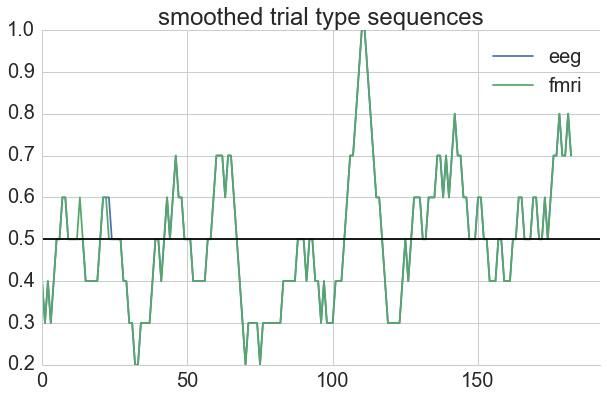

In [12]:
plt.figure(figsize=(10, 6))

modalities = ['eeg', 'fmri']
for i, modality in enumerate(modalities):
    trial_types = tidy_df.xs(modality, level='modality') \
                         .trial_type.astype('category').cat.codes
    plt.plot(np.convolve(trial_types, np.ones((10,))/10, mode='valid'))
    
plt.legend(modalities)
plt.axhline(0.5, color='k')
plt.title('smoothed trial type sequences')
plt.xlim((0, len(trial_types)))

sns.despine()
plt.show()

The time series above are smoothed with a moving average of every 10 timepoints. This allows us to get a sense of how the relative fractions of congruent vs. incongruent trials change throughout the experiment. The relative fraction is typically fairly centered around 0.5 (the mean is 0.5 since we do have an equal fraction across the entire experiment) with the exception of a particularly strong incongruent bias around 100 trials in. Note that there is a bit of a congruent bias in the first half of the experiment and then a more incongruent bias in the second half of the experiment, but it is relatively minor.

One interesting peculiarity is that the eeg and fmri trial sequences appear to be identical with the exception of a difference somewhere around trial 25. I would have expected them to be more different given that the n-1 sequence counts were different, but it looks as if those n-1 trial sequence count differences may have been due to a single shift. Let's investigate.

In [13]:
eeg = tidy_df.xs('eeg', level='modality') \
             .trial_type.astype('category').cat.codes
fmri = tidy_df.xs('fmri', level='modality') \
             .trial_type.astype('category').cat.codes
print(np.where(np.abs(eeg - fmri) > 0))
print(eeg[20:25])
print(fmri[20:25])

(array([22, 23]),)
trial
21    0
22    1
23    0
24    1
25    0
dtype: int8
trial
21    0
22    1
23    1
24    0
25    0
dtype: int8


Very peculiar. Trials 23 and 24 are swapped between the eeg and fmri versions. I have no idea why the trial sequences would be different like this. I would either expect them to be completely different or exactly identical. In any case, we can conclude that the trial sequences are effectively identical though there is this one small difference.

#### Trial Timing

First, let's see what the total run time of our tasks was:

In [18]:
def time_column(seq):
    m, s = seq // 60, seq % 60
    return '%d min %d sec' % (m, s)

tidy_df['trial_time'] = tidy_df['duration'] + tidy_df['iti']
tidy_df['trial_time'].groupby(level=0) \
                     .aggregate(sum) \
                     .transform(time_column)

modality
eeg     11 min 59 sec
fmri     6 min 37 sec
Name: trial_time, dtype: object

So we see that the eeg version is almost twice as long. Since they have the same trial counts, this must stem from timing differences. We check the response windows.

In [21]:
tidy_df.groupby([pd.Grouper(level=0), 'duration']).duration.count()

modality  duration
eeg       1.75        192
fmri      1.75        192
Name: duration, dtype: int64

So every response was limited to 1.75 seconds. This isn't the difference since the task did not advance on a response being made. The difference must stem from the inter-trial interval differences so let's take a look at those:

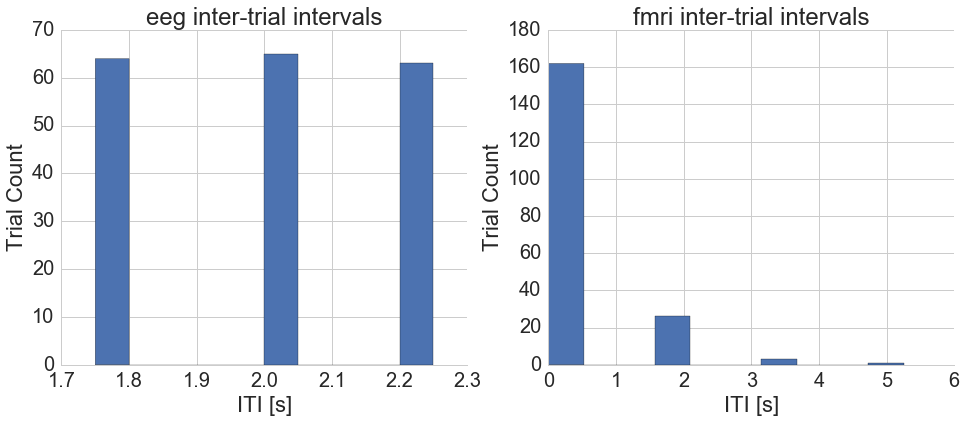

In [22]:
f, axs = plt.subplots(1, 2, figsize=(16, 6))

for i, modality in enumerate(['eeg', 'fmri']):
    itis = tidy_df.xs(modality, level='modality').iti
    axs[i].hist(itis)
    axs[i].set_title('%s inter-trial intervals' % modality)
    axs[i].set_xlabel('ITI [s]')
    axs[i].set_ylabel('Trial Count')

sns.despine()
plt.show()


plt.show()

So we see that the EEG design has an ITI distribution ~ U([1.75, 2, 2.25]). It is important that the ITI is not purely constant as this variation (often referred to as jitter) prevents predicting the upcoming trial onset which can affect the baseline period of the eeg signal. For the fmri, we see that the majority of the differences are 0 with some out at around 2, 3.5 and 5 in decreasing amounts. I'm not entirely sure on the basis of this ITI distribution, but supposedly it was determined by optseq to provide an optimal design given the trial design and trial counts. We can clearly see that the difference in timing comes from the fmri iti's being predominantly 0.

## Summaries & Exclusions 

### Visualize Exclusion Metrics

Here we will check some measures to determine if any subject's data should be excluded based on 3 different factors:

- Non-reponses: Non-responses can imply that a person struggled with a trial and wasn't able to respond in time. Or more problematically, they can imply a lack of engagement with the task (in the worst case, they may even be dozing off). An excessive non-response rate may suggest grounds for exclusion since it signals severe disengagement and a serious reduction of available data.
- Errors: While errors in and of themselves aren't bad and suggest the task has some difficulty to it, excessive errors could imply an inability to understand the task. In the extreme case, they could also signal indiscriminate responding or a misunderstanding of the task rules.
- Fast Responses: Large amounts of fast responses (defined here as less than 200 ms) could imply that the subject was again indiscriminately responding since responses at this speed are too fast to have resolved the correct response. 

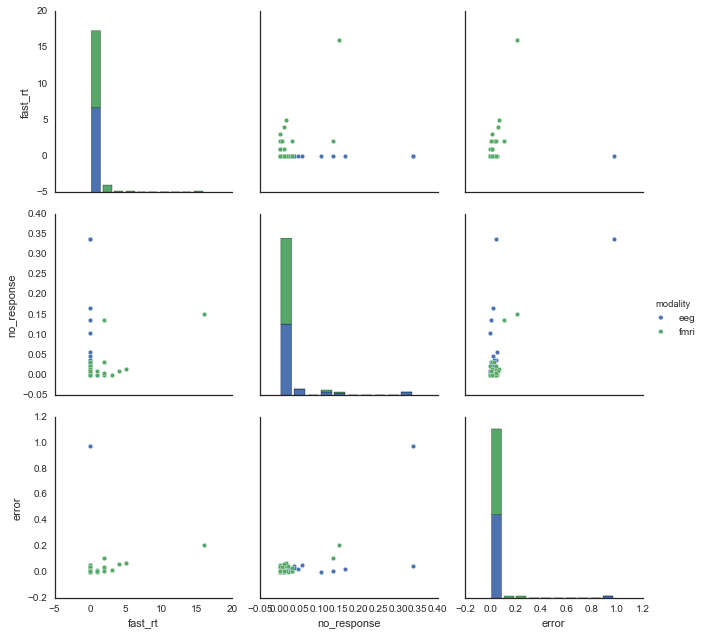

In [31]:
tidy_df = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                      sep='\t', na_values='n/a')

agg_df = tidy_df[['participant_id', 'modality', 'error', 'no_response', 
                  'fast_rt']] \
             .groupby(['participant_id', 'modality'], as_index=False) \
             .agg({'error': 'mean', 'no_response': 'mean',
                   'fast_rt': 'sum'}) 
        
sns.pairplot(agg_df, hue='modality', size=3, aspect=1)
plt.show()

A few outliers immediately jump out:
- We have an eeg participant who had nearly a 100 percent error rate on top of a 30 percent missing rate who we will definitely need to exclude. I'm not exactly sure how they had such a high error rate. Even random responding would be expected to result in a lower error rate. On top of that, they did the task without an excessive error rate in the fmri prior to the eeg version. Even if they were responding according to an incorrect rule (i.e. location instead of identity), I still wouldn't expect the error rate to be that high. 
- We have a fmri participant who had a fairly large error rate (~20%) and a large number of fast responses and fairly large non_reponse rate. This is again suggestive of someone who was not engaged. They were responding before ability to judge the response frequently, they were getting a lot of trials wrong (probably a lot due to the fast responses), and they didn't engage with 10-20% of the trials. Probably grounds for exclusion.
- There is another individual who didn't respond on greater than 30% of trials. Though they didn't have a particularly large error rate, this is still a significant percentage of trials to not respond and probably grounds for exclusion.

Some comments on distributions:
- Fast responses: Apart from our outlier, our fast responses are very reasonable with the next highest value being around 5 or so and most being at 0.
- Slow responses: We again see a reasonable distribution with the max being 5 and the density being most around 2 or 3.
- Error: Apart from two of our outliers, the vast majority of our the density lies around 0. While it is nice not to have too many excessive error rates, this also seems to hint that we may not have enough errors to be able to explore them as a dependent variable. We'll look more closely later.
- Non-Reponses: The vast majority of the density is clustered around 0. We have the two outliers out at around 30%. We also have a smaller cluster of individuals around 10-20% that we should be wary of.

### Subject Exclusions

Here we will actually denote subject exclusions. To avoid complete subjectivity, we'll use a more objective criterion for exclusion. Since all of our exclusion metrics above lead to data lost, we can collapse all of our metrics into a single metric: the number of non-excluded trials. We can then define a threshold for outliers along this metric. Here we'll use the following metric:

Exclude subject if number of trials after all exclusions < (median - 3 * mad) 

This is similar to z-scoring, but we use robust versions of the mean and standard deviation since we know our distribution will be skewed with some large outliers. The three is somewhat arbitrary and comes as a slightly more data keeping conservative threshold than the 2 standard deviations I've seen typically.

eeg
Threshold: 154 trials
Rejected Subjects:
   participant_id modality  fast_rt  no_response     error
24      sub-hc013      eeg        0     0.338542  0.976378
52      sub-hc027      eeg        0     0.338542  0.047244
fmri
Threshold: 173 trials
Rejected Subjects:
   participant_id modality  fast_rt  no_response     error
53      sub-hc027     fmri        2     0.135417  0.108434
75      sub-hc041     fmri       16     0.151042  0.208589


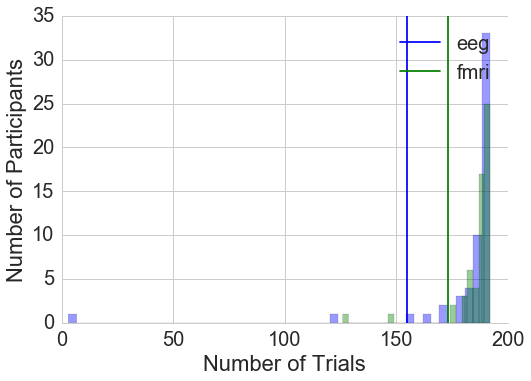

In [2]:
tidy_df = pd.read_csv('../data/derivatives/behavior/group_data.tsv',
                      sep='\t', na_values='n/a')
exclusions = {}

# Create a new column that is 0 if a trial passes all of our exclusion
# metrics
exclusion_columns = ['error', 'no_response', 'fast_rt']
tidy_df = tidy_df[['participant_id', 'modality'] + exclusion_columns]
tidy_df['exclude'] = tidy_df.sum(axis=1)

# Create a summary dataframe with non-excluded trial counts
trial_count_df = tidy_df[tidy_df.exclude == 0] \
                 .groupby(['participant_id', 'modality'],
                          as_index=False) \
                 .agg('count')

# Create a summary dataframe with exclusion metrics for each participant
# modality pairing
agg_df = tidy_df.groupby(['participant_id', 'modality'], as_index=False) \
                .agg({'error': 'mean', 'no_response': 'mean',
                      'fast_rt': 'sum'})

# Iterate through modalities
for col, mod in zip(['b', 'g'], ['eeg', 'fmri']):
    print(mod)
    
    exclusions[mod] =[] 
    
    # Subset our summary dataframes by modality
    trial_mod_df = trial_count_df[trial_count_df.modality == mod]
    agg_mod_df = agg_df[agg_df.modality == mod]
    
    # Calculate exclusion threshold
    threshold = trial_mod_df['error'].median() - \
                3 * trial_mod_df['error'].mad()
    print('Threshold: %d trials' % threshold)
    
    # Plot distribution of trials counts with threshold cutoff
    sns.distplot(trial_mod_df['error'], norm_hist=False, kde=False, 
                 color=col)
    plt.axvline(threshold, color=col, label='__no_legend')
    
    # Extract subject indices of excluded subjects by threshold
    sub_ix = np.where(trial_mod_df['error'] < threshold)[0]
    
    print('Rejected Subjects:')
        
    # show exclusion information
    sub = agg_mod_df.iloc[sub_ix, :]
    print(sub)
        
    # update our exclusions dictionary
    exclusions[mod] += list(sub.participant_id)
        
        
# Pretty plot and show
plt.xlabel('Number of Trials')
plt.ylabel('Number of Participants')
plt.legend(['eeg', 'fmri'])
sns.despine()
plt.show()            

We've selected out the very worst offenders in the EEG. We've also picked out two bad subjects in the fmri who lost over a quarter of trials when taking fast responses, no_responses, and errors together. We write these exclusions out to file below.

In [4]:
denote_exclusions(exclusions['fmri'], 'behavior_fmri')
denote_exclusions(exclusions['eeg'], 'behavior_eeg')

# EEG Preprocessing

## Initialization 

EEG isn't standardly supported by the BIDS specification yet. However, we still try to stay reasonably close to the derivatives philosophy currently under development. Thus the preprocessing section (which culminates in cleaned epochs) is stored as an eeg_preprocessing BIDS-derivatives compatible pipeline in the data/derivatives/eeg_preprocessing folder.

In [1]:
%reset -f
from grabbit import Layout
import json
import pickle
import pandas as pd
import numpy as np
from mne.io import Raw
from mne.preprocessing import read_ica
from mne import Epochs, set_log_level, find_events, read_epochs
from autoreject import LocalAutoRejectCV, compute_thresholds
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

from msit import verify_events, epoch_baseline_correct, CH_NAMES
from msit import handle_event_exceptions, visually_verify_epochs
from msit import plot_autoreject_summary, plot_evoked_butterfly
from msit import select_subjects, extract_bad_ch_group_info
from msit import plot_bad_chs_group_summary, extract_bad_epochs_group_info
from msit import denote_exclusions

%matplotlib
set_log_level('critical')

# load eeg configurations
with open('../config.json') as f:    
    config = json.load(f)

# make_eeg_prep_derivatives_folder('../data')
layout = Layout('../data', '../data/grabbit_config.json')
pipeline_root = '../data/derivatives/eeg_preprocessing'

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using matplotlib backend: Qt4Agg


## Mark Bad Channels


In [1]:
# extract participant raw filenames
raw_files = layout.get(subject='sub-.*', modality='eeg', 
                       extensions='.fif')

# iterate through participant raw data
for f in raw_files:
    manually_mark_bad_channels(f)

Using matplotlib backend: Qt4Agg


## ICA

### Fit ICA & Auto-Mark EOG & ECG Components

In [ ]:
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from mne import set_log_level
from mne.io import Raw
from grabbit import Layout
import numpy as np
import matplotlib.pyplot as plt

set_log_level('critical')

pipeline_root = '../data/derivatives/eeg_preprocessing'

# extract participant raw filenames
layout = Layout('../data', './grabbit_config.json')
raw_files = layout.get(subject='sub-.*', modality='eeg', 
                       extensions='_raw.fif')

# iterate through participant 
for f in raw_files:
    
    print(f.subject)
    
    # load in raw with existing bad channels
    raw = Raw(f.filename, verbose=False, preload=True)
    bad_ch_f = layout.get(subject=f.subject, modality='eeg', 
                          derivative='bad_chs')[0].filename
    raw.load_bad_channels(bad_ch_f)
    
    # highpass filter the raw to assist with ICA fitting
    raw.filter(l_freq=1, h_freq=None)
    
    # extract the number of channels to be fit for ICA
    n_components = raw.estimate_rank()
    
    # fit the ica solution
    ica = ICA(n_components=n_components, random_state=50)
    ica.fit(raw, verbose=False)
    
    # save out plots of components
    fig = ica.plot_components(picks=np.arange(n_components), show=False)
    fig.savefig('%s/%s/ica/%s-components.png' % (pipeline_root, f.subject, 
                                                 f.subject))
    
    # iterate through eog and ecg channels
    for ch in ['VEOG', 'HEOG', 'ECG']:
        
        # find the correlation scores between components
        if 'EOG' in ch:
            epochs = create_eog_epochs(raw, ch_name=ch)
            ix, scores = ica.find_bads_eog(epochs, ch_name=ch)
        else:
            epochs = create_ecg_epochs(raw, tmin=-.5, tmax=.5)
            ix, scores = ica.find_bads_ecg(epochs)
            
        # update the ica with the bad components
        ica.labels_[ch] = ix
        ica.exclude += ix
        
        # save correlation scores plot
        fig = ica.plot_scores(scores, exclude=ix, show=False)
        fig.savefig('%s/%s/ica/%s_%s-scores.png' % (pipeline_root,
                                                    f.subject, f.subject,
                                                    ch))
        
    # clean up labels and save ica solution out    
    ica.labels_ = {ch: ica.labels_[ch] for ch in ['VEOG', 'HEOG', 'ECG']}    
    ica.save('%s/%s/ica/%s-ica.fif' % (pipeline_root, f.subject, f.subject))
    plt.close('all')
    
print('Done!')

### Verify ICA Artifact Components

In [ ]:
from mne.preprocessing import read_ica
from mne import set_log_level
from mne.io import Raw
from grabbit import Layout
import numpy as np
import pylab as plt
from eeg_utilities import *

%matplotlib

set_log_level('critical')

pipeline_root = '../data/derivatives/eeg_preprocessing'

# extract participant raw filenames
layout = Layout('../data', './grabbit_config.json')
ica_files = layout.get(subject='sub-pp0[0-4][0-9]', modality='eeg', derivative='ica',
                       extensions='-ica.fif')
raw_files = layout.get(subject='sub-pp0[0-4][0-9]', modality='eeg',
                       extensions='_raw.fif')

# iterate through participants
for raw_f, ica_f in zip(raw_files, ica_files):
    
    print(raw_f.subject)
    ica = read_ica(ica_f.filename)
    raw = Raw(raw_f.filename, preload=True, verbose=False)
    bad_ch_f = layout.get(subject=raw_f.subject, modality='eeg', 
                          derivative='bad_chs')[0].filename
    raw.load_bad_channels(bad_ch_f)
    raw.filter(l_freq=1, h_freq=None)
    
    # repeatedly visualize and adjust excluded components until happy
    ok = 'n'
    while ok != 'y':
    
        # plot summary of corrections epoched to artifact events
        # we use these plots to determine how effective our ica is
        # at correcting the artifacts
        plot_epoched_ica_artifact_info(raw, ica, raw_f.subject, 
                                       pipeline_root)
        
        # plot component time courses for interactive updating of exclusions
        ica.plot_sources(raw, block=True, title=raw_f.subject)
        
        # plot summary of corrections epoched to artifact events
        # we use these plots to determine how effective our ica is
        # at correcting the artifacts
        plot_epoched_ica_artifact_info(raw, ica, raw_f.subject, 
                                       pipeline_root)
        plt.close('all')
        ok = raw_input('OK to move on? (enter y or n):')
        
    ica.save('%s/%s/ica/%s-ica.fif' % (pipeline_root, raw_f.subject, 
                                       raw_f.subject))
print('Done!')

## Generate  & Clean Epochs

### Bandpass Filter & Make Epochs

In [2]:
# extract participant raw, ica, and behavior filenames
layout = Layout('../data', '../data/grabbit_config.json')
ica_files = layout.get(subject='sub-.*', derivative='eeg_preprocessing', 
                       extensions='-ica.fif')
raw_files = layout.get(subject='sub-.*', modality='eeg', 
                       extensions='_raw.fif')
behavior_files = layout.get(subject='sub-.*', modality='eeg',
                            extensions='events.tsv')

# iterate through participants
for raw_f, ica_f, b_f in zip(raw_files, ica_files, behavior_files):
    
    print(raw_f.subject)
        
    # load in data files
    ica = read_ica(ica_f.filename)
    raw = Raw(raw_f.filename, preload=True, verbose=False)
    behavior = pd.read_csv(b_f.filename, sep='\t', na_values='n/a')
    
    # process subject behavior
    behavior = behavior[behavior.trial_type != 'fixation']
    no_response_ix = np.where(behavior.response_time.isnull())[0]
    
    # mark bad channels
    bad_ch_f = layout.get(subject=raw_f.subject, 
                          derivative ='eeg_preprocessing', 
                          extensions='bad_chs.txt')[0].filename
    raw.load_bad_channels(bad_ch_f)
    
    # remove ICA artifacts
    raw = ica.apply(raw, exclude=ica.exclude)
    
    # bandpass filter
    raw.filter(l_freq=config['filter_high_pass'], 
               h_freq=config['filter_low_pass'])
    
    # iterate through epoch types
    for epo_type, event_ch, time_bound in zip(config['epoch_types'],
                                              config['event_channels'],
                                              config['epoch_times']):
    
        # extract events 
        events = find_events(raw, stim_channel=event_ch, output="onset", 
                             verbose=False)

        # verify events
        try:
            verify_events(events, behavior, epo_type)
        except ValueError as err:
            print(err)
            events, no_response_ix = handle_event_exceptions(raw_f.subject, 
                                                              epo_type, 
                                                              events,
                                                              no_response_ix)
        # make epochs
        epochs = Epochs(raw, events, 
                        tmin=time_bound[0] - config['filter_buffer'], 
                        tmax=time_bound[1] + config['filter_buffer'], 
                        baseline=None, proj=False, detrend=1,
                        preload=True, verbose=False, 
                        reject_by_annotation=False)
        
        # remove non-responses
        if epo_type != 'response':
            epochs.drop(no_response_ix)
        
        # baseline correct
        # assumes that the epochs type containing the baseline is the 
        # first in the list
        if epo_type == config['baseline_container']:
            baseline = epochs.copy().crop(config['baseline_period'][0],
                                          config['baseline_period'][1])
        epochs = epoch_baseline_correct(epochs, baseline.get_data())
        print(epochs)
        
        # save to file
        f = '%s/%s/epochs/%s_%s_uncleaned-epo.fif'
        epochs.save(f % (pipeline_root, raw_f.subject, raw_f.subject, 
                         epo_type))
print('Done!')    

sub-hc001
<Epochs  |  n_events : 181 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~382.2 MB, data loaded>
<Epochs  |  n_events : 181 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~353.2 MB, data loaded>
sub-hc002
<Epochs  |  n_events : 190 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~401.0 MB, data loaded>
<Epochs  |  n_events : 190 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~370.5 MB, data loaded>
sub-hc003
<Epochs  |  n_events : 191 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~403.1 MB, data loaded>
<Epochs  |  n_events : 191 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~372.5 MB, data loaded>
sub-hc004
<Epochs  |  n_events : 192 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~405.2 MB, data loaded>
<Epochs  |  n_events : 192 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~374.4 MB, data loaded>
sub-hc005
<Epochs  |  n_events : 192 (all good), tmi

sub-hc036
<Epochs  |  n_events : 191 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~403.1 MB, data loaded>
<Epochs  |  n_events : 191 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~372.5 MB, data loaded>
sub-hc037
<Epochs  |  n_events : 191 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~403.1 MB, data loaded>
<Epochs  |  n_events : 191 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~372.5 MB, data loaded>
sub-hc042
<Epochs  |  n_events : 186 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~392.7 MB, data loaded>
<Epochs  |  n_events : 186 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~362.9 MB, data loaded>
sub-hc044
<Epochs  |  n_events : 160 (all good), tmin : -1.0 (s), tmax : 2.25 (s), baseline : None, ~338.5 MB, data loaded>
<Epochs  |  n_events : 160 (all good), tmin : -1.5 (s), tmax : 1.5 (s), baseline : None, ~312.9 MB, data loaded>
sub-hc045
<Epochs  |  n_events : 166 (all good), tmi

### Autoreject

In [1]:
subjects = np.array(sorted(layout.get(target='subject', 
                                      modality='eeg',
                                      return_type='id')))
start_ix = np.where(subjects == 'sub-hc033')[0][0]
end_ix = np.where(subjects == 'sub-pp001')[0]
subjects = subjects[start_ix:]

# parallelize and seed autoreject threshold function
thresh_func = partial(compute_thresholds, random_state=42, n_jobs=5)

# iterate through epoch types
for sub in subjects:
    
    print(sub)
    epochs = []
    ar_epochs = []
    
    for epo_type, time_bound in zip(config['epoch_types'],
                                    config['epoch_times']):
        print(epo_type)
    
        # load uncleaned epochs
        epoch_file = layout.get(subject=sub, 
                                derivative='eeg_preprocessing', 
                                extensions='%s_uncleaned-epo.fif' % epo_type)
        epoch = read_epochs(epoch_file[0].filename, verbose=False)
        
        # fit autoreject
        ar = LocalAutoRejectCV(consensus_percs=config['consensus_percs'],
                               n_interpolates=config['n_interpolates'],
                               thresh_func=thresh_func, verbose=False)
        ar.fit(epoch)
        
        # save autoreject to file
        pickle_file = '%s/%s/autoreject/%s_%s_ar.pkl' % (pipeline_root,
                                                         sub, sub,
                                                         epo_type)
        with open(pickle_file, 'w') as output:
            pickle.dump(ar, output, pickle.HIGHEST_PROTOCOL)
            
        # create and save autoreject diagnostic plot
        plot_autoreject_summary(ar, sub, epo_type, pipeline_root,
                                epoch.ch_names)
        plt.close('all')
        
        epochs.append(epoch)
        ar_epochs.append(ar.transform(epoch))
        
    # plot evoked data before and after autoreject
    for period, epos in zip(['before', 'after'], [epochs, ar_epochs]):
        fig = plot_evoked_butterfly(epos, config)
        fig.suptitle('%s %s Autoreject' % (sub, period.capitalize()))
        f = ('%s/%s/autoreject/%s_%s_autoreject_butterfly.png')
        fig.savefig(f % (pipeline_root, sub, sub, period))
        plt.close(fig)
    plt.close('all')
        
print('Done!')

/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using matplotlib backend: Qt4Agg
sub-hc033
stimulus
response
0


/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


1
0
1
sub-hc034
stimulus
response
0
1
0
1
sub-hc035
stimulus
response
0
1
0
1
sub-hc036
stimulus
response


/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/autoreject-0.1.dev0-py2.7.egg/autoreject/autoreject.py:640: UserWarning: No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


0
1
0
1
sub-hc037
stimulus
response
0
1
0
1
sub-hc042
stimulus
response
0
1
0
1
sub-hc044
stimulus
response
0
1
0
1
sub-hc045
stimulus
response
0
1
0
1
sub-pp001
stimulus
response
0
1
0
1
sub-pp002
stimulus
response
0
1
0
1
sub-pp003
stimulus
response
0
1
0
1
sub-pp004
stimulus
response
0
1
0
1
sub-pp005
stimulus
response
0
1
0
1
sub-pp006
stimulus
response
0
1
0
1
sub-pp007
stimulus
response
0
1
0
1
sub-pp008
stimulus
response
0
1
0
1
sub-pp009
stimulus
response
0
1
0
1
sub-pp010
stimulus
response
0
1
0
1
sub-pp011
stimulus
response
0
1
0
1
sub-pp012
stimulus
response
0
1
0
1
sub-pp013
stimulus
response
0
1
0
1
sub-pp014
stimulus
response
0
1
0
1
sub-pp015
stimulus
response
0
1
0
1
sub-pp016
stimulus
response
0
1
0
1
Done!


### Update Bad Channels & Average Re-Reference

Notes:
- hc004: occipitals have a weird linear increasing baseline (even though linear detrended?)
- hc008: funky oscillations - alpha? Just generally really noisy.
- hc018: exclude- more than half of channels bad.
- hc029: noisy with lots of bad channels
- hc045: frontals not flat in baseline, maybe missing ica components?
- pp001: just looks like noise
- pp004: looks really bad, didn't even try to throw out channels
- pp013: weird positive frontal and negative occipital linear trends



In [ ]:
subjects = np.array(sorted(layout.get(target='subject', 
                                      modality='eeg',
                                      return_type='id')))
start_ix = np.where(subjects == 'sub-hc022')[0][0]
end_ix = np.where(subjects == 'sub-hc024')[0][0]
subjects = subjects[start_ix:end_ix + 1]
    
# iterate through participants
for sub in subjects:
    
    print(sub)
    
    # load and autoreject transform epochs
    epoch_files = layout.get(subject=sub,
                         derivative='eeg_preprocessing',
                         extensions='uncleaned-epo.fif')
    ar_files = layout.get(subject=sub,
                          derivative='eeg_preprocessing',
                          extensions='ar.pkl')
    epochs = [read_epochs(f.filename, verbose=False) 
              for f in epoch_files][::-1]
    ars = [pickle.load(open(f.filename, 'r')) for f in ar_files][::-1]
    epochs = [ar.transform(epoch) for ar, epoch in zip(ars, epochs)]
        
    # visually verify and update bad channels on epochs
    bad_chs = visually_verify_epochs(sub, epochs, config)
    
    # update bads and average re-reference
    for epoch in epochs:
        epoch.info['bads'] = bad_chs
        epoch.set_eeg_reference().apply_proj()
        
    # save cleaned epochs to file
    for i, epo_type in enumerate(config['epoch_types']):
        f = '%s/%s/epochs/%s_%s_cleaned-epo.fif'
        epochs[i].save(f % (pipeline_root, sub, sub, epo_type))
        
    # save cleaned epochs butterfly plot
    [epochs[i].crop(config['epoch_times'][i][0], 
                config['epoch_times'][i][1]) for i in range(len(epochs))]
    fig = plot_evoked_butterfly(epochs, config)
    fig.suptitle('%s Cleaned' % sub)
    f = '%s/%s/%s_cleaned_butterfly.png'
    fig.savefig(f % (pipeline_root, sub, sub))
        
    # save channel sensors plot
    fig = epochs[0].plot_sensors(show=True, title=sub, show_names=True)
    fig.savefig('%s/%s/%s_sensors.png' % (pipeline_root, sub, sub))
    plt.close('all')
        
print('Done!')

Using matplotlib backend: Qt4Agg
sub-hc022


/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/autofs/space/cassia_001/users/matt/software/anaconda2.7/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


## Summaries and Exclusions 

### Bad Channel Summary

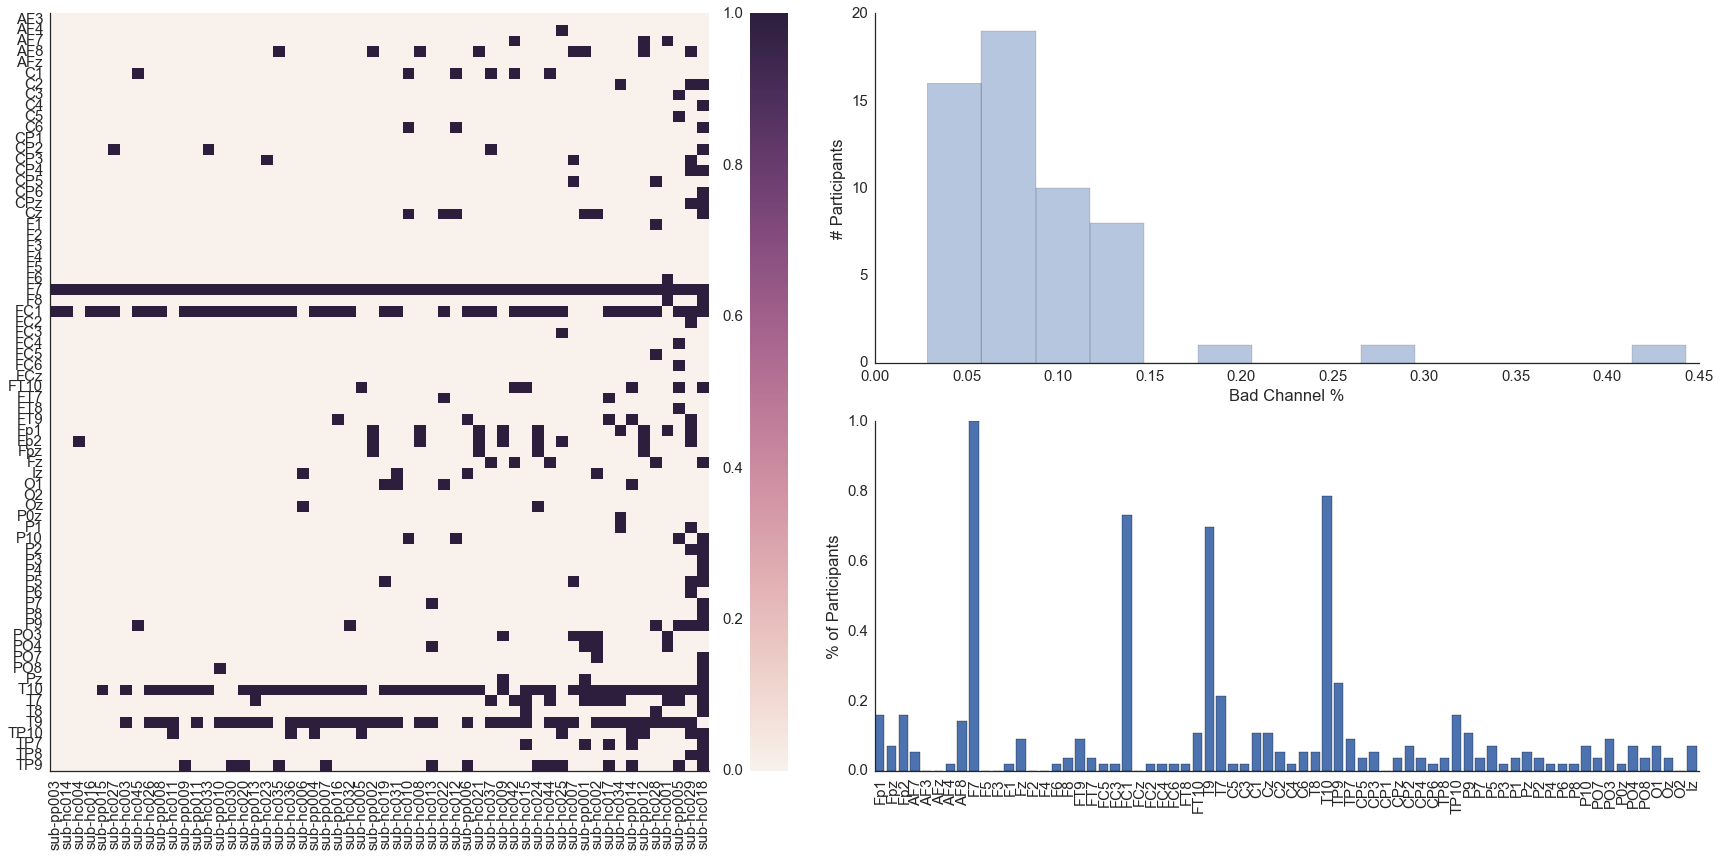

In [10]:
%matplotlib inline
bad_ch_info = extract_bad_ch_group_info('../data/derivatives/eeg_preprocessing', CH_NAMES)
fig = plot_bad_chs_group_summary(bad_ch_info)
plt.show(fig)

### Bad Epochs Summary

In [2]:
bad_epoch_info = extract_bad_epochs_group_info('../data/derivatives/eeg_preprocessing', CH_NAMES)

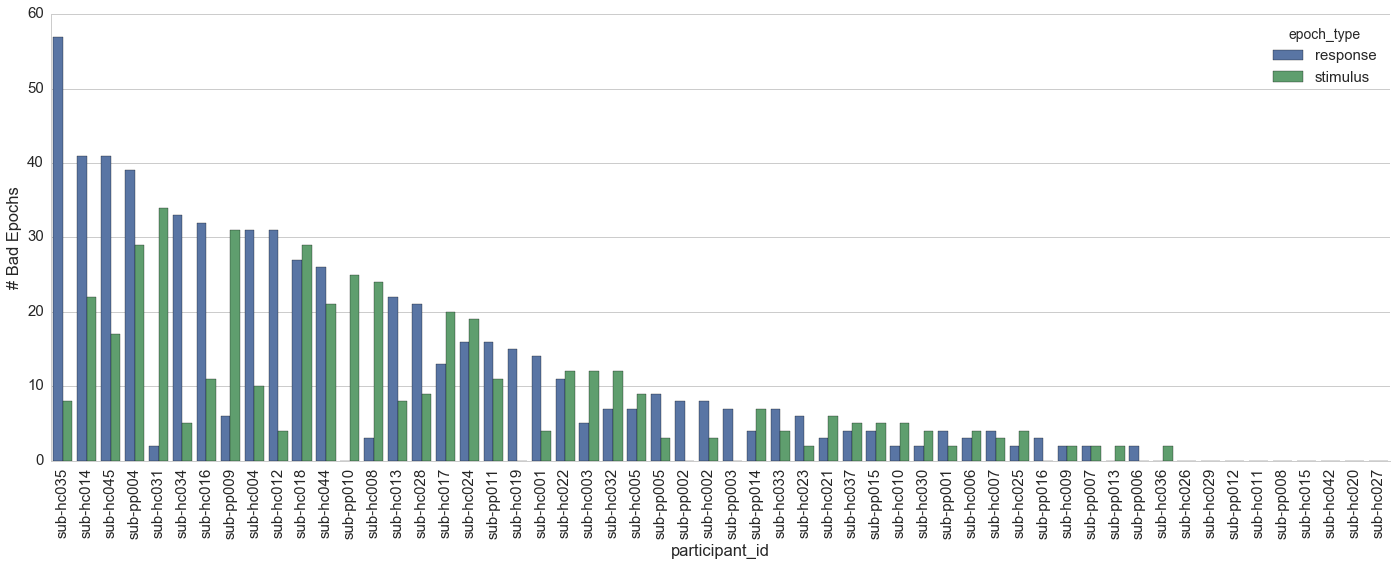

In [3]:
%matplotlib inline
plt.figure(figsize=(24, 8))
sns.barplot(x='participant_id', y='num_bad', hue='epoch_type', 
            data=bad_epoch_info.sort_values(by='num_bad', ascending=False))
plt.xticks(rotation=90)
plt.ylabel('# Bad Epochs')
sns.despine()
plt.show()

### Subject Exclusions

At least for a first pass, I am going to be very data keeping conservative and only exclude hc018 because they had nearly half of their channels bad.

In [6]:
denote_exclusions(['sub-hc018'], 'eeg')

# fMRI Preprocessing